<a href="https://colab.research.google.com/github/GonMazzini/Loads_Surrogate_Transferability/blob/main/PyTorch_Model_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

% Saved 5/3/2022    13:25
- Try outputs e inputs with different scaler?
- Add one more layer?
- Add cuda to run in collab

In [4]:
import pandas as pd 
import numpy as np
import math
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


# 0- Read the data as a data frame

In [6]:
df = pd.read_excel('LoadsDataBase_6D_Set123_FiltMinMaxCrit.xlsx') # Average the values from Set1,Set2 and Set3.
df.head(2)
# 0 : TT_Mx_avg
# 1 : TT_My_avg
# 2 : TB_Mx_avg
# 3 : TB_My_avg
# 4 : MS_Mz_avg
# 5 : BR_Mx_avg
# 6 : BR_My_avg
# 7 : TT-Mz_avg

,Unnamed: 0,pointno,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi,TT_Mx_avg,TT_My_avg,TB_Mx_avg,TB_My_avg,TT_Mz_avg,MS_Mz_avg,BR_Mx_avg,BR_My_avg
0,0,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000,747.561872,200.666288,6708.717789,8861.885588,819.209904,63.457528,4253.317748,15006.726860
1,1,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217,3556.031457,676.339081,16692.647572,6329.099515,3746.460605,1354.995442,10409.290476,16289.414152


# ============================================================
# ==========================Section 1 ==========================
# ============================================================

In [7]:
X = df.iloc[:,2:8]
y = df.iloc[:,8:]

In [8]:
# Test split:
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True,  random_state = 101)

print(f'The filtered data set consits on: {len(df)} entries.')
print(f'A total of {len(X)} will be used for training and validation.')
print(f'A total of {len(X_test)} will be used for testing the final model.')




The filtered data set consits on: 7664 entries.
A total of 6131 will be used for training and validation.
A total of 1533 will be used for testing the final model.


### From now on, "X" and "y" will be used for train-validate the model. 

In [9]:
feature_range = (0, 1)
scaler_x = preprocessing.MinMaxScaler(feature_range=feature_range).fit(X)
X_scaled = scaler_x.transform(X)

### Separte between train and validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled,y.values, test_size = 0.2, shuffle = True,  random_state = 101)

# printing number of samples for train-validation-test
print(f'A total of {y_train.shape[0]} for training, {round(100*y_train.shape[0]/len(df),1)} % of total data')
print(f'A total of {y_val.shape[0]} for validation, {round(100*y_val.shape[0]/len(df),1)} % of total data')
print(f'A total of {y_test.shape[0]} for testing, {round(100*y_test.shape[0]/len(df),1)} % of total data')

A total of 4904 for training, 64.0 % of total data
A total of 1227 for validation, 16.0 % of total data
A total of 1533 for testing, 20.0 % of total data


### The PyTorch worfklow can be summarized as follows:
- 1) Design model (input, output size, forward pass)
- 2) Construct loss and optimizer
- 3) Training loop
   - forward pass: compute prediction based on the current weights and biases of the net
   - backward pass: compute the gradients of the loss function wrt. to model parameters
   - update weigths in

In [11]:
input_size = 6             # np.shape(X_train)[1]
output_channels = 8        # np.shape(y_train)[1]
num_hid_1 = 50
num_hid_2 = 50

In [12]:
class Net(nn.Module):
    
    def __init__(self, num_hid_1, num_hid_2):   
        super(Net,self).__init__()  # inherit from the superclass Module
        self.num_hid_1 = num_hid_1
        self.num_hid_2 = num_hid_2
        
        self.fc1 = nn.Linear(in_features= input_size,
                             out_features= self.num_hid_1,                             
                            bias = True)  
        
        self.fc2 = nn.Linear(in_features = self.num_hid_1, 
                             out_features = self.num_hid_2,
                            bias = True)
        
        self.fc3 = nn.Linear(in_features = self.num_hid_2, 
                             out_features = output_channels,
                            bias = True)
        
#        self.dropout = nn.Dropout(p=0.15)
        
    def forward(self,x):
        
        out = self.fc1(x)  
#        out = self.dropout(out)
        out = F.relu(out)
        out = self.fc2(out)
#        out = self.dropout(out)
        out = F.relu(out)
        out = self.fc3(out)                       #  torch.tanh(self.fc3(out))
        
        return out  

In [13]:
# instantiate the class
model = Net(num_hid_1,num_hid_2)

if torch.cuda.is_available():
  model.to(device)

# Define the loss function (mean square error)
loss = nn.MSELoss()

# Instantiate optimizer passing the net parameters as argument, and learning rate
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# list to store results
train_losses , val_losses= [],[]



In [14]:
# Try a dummy forward
model(torch.tensor(X_train[0]).float().to(device))  # beware that need to convert from double to float

tensor([ 0.0802,  0.0496,  0.1292, -0.0897,  0.2109,  0.0153, -0.2685,  0.1344],
       device='cuda:0', grad_fn=<AddBackward0>)

# 2.1- Use the PyTorch DataLoader and Dataset utils.
- DataLoader class combines a dataset and a sampler, and provides an iterable over the given dataset for training the model
- Dataset: just an abstract class representing a :class:`Dataset`

In [15]:
class FatigueLoads_TrainSet(Dataset):

    def __init__(self):
        self.n_samples = X_train.shape[0]
        self.x_data = torch.from_numpy(X_train) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y_train) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    
class FatigueLoads_ValidationSet(Dataset):

    def __init__(self):
        self.n_samples = X_val.shape[0]
        self.x_data = torch.from_numpy(X_val) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y_val) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

### Get first sample and unpack. Note that the enviromental inputs are normalized using MinMaxScaler

In [16]:
train_dataset = FatigueLoads_TrainSet()
valid_dataset = FatigueLoads_ValidationSet()

first_data = train_dataset[0]
features, loads = first_data
print(features, loads)

tensor([0.9213, 0.5395, 0.2971, 0.1574, 0.7369, 0.3075], dtype=torch.float64) tensor([ 7116.1376,   808.7441, 21966.9989, 16383.7768,  7347.3186,   807.4632,
        18567.6736, 16935.8620], dtype=torch.float64)


In [17]:
batch_size = 128
num_epochs = 1200

num_batches_train = X_train.shape[0] // batch_size
num_batches_test = X_val.shape[0] // batch_size

print(f'Num batches train: {num_batches_train}')
print(f'Num batches valid: {num_batches_test}')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

Num batches train: 38
Num batches valid: 9


# 3.1- Start training loop 

In [18]:
%%time
for epoch in tqdm(range(num_epochs)):
    
    epoch_loss = 0
    model.train()
    
    for i, (inputs, loads) in enumerate(train_loader):
        #print(features, loads)
        
        optimizer.zero_grad()                      # zeroize accumulated gradients in parameters             
        
        output = model(inputs.float().to(device))             # forwards pass       
        batch_loss = loss(output, loads.float().to(device))   # compute loss for current batch
        
        batch_loss.backward()                      # compute the gradient of the loss wrt. model parameters
        optimizer.step()                           # update weights according to the comptued gradients
        
    
    epoch_loss_train = 0
    epoch_loss_test = 0
    model.eval()
    
    ##### Evaluate training
    for i, (inputs, loads) in enumerate(train_loader):
        
        output = model(inputs.float().to(device))
        
        batch_loss_train = loss(output, loads.float().to(device))  # compute loss for the current batch
        epoch_loss_train += batch_loss_train            # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    ##### Evaluate validation    
    for i, (inputs, loads) in enumerate(valid_loader):
        
        output = model(inputs.float().to(device))
        
        batch_loss_test = loss(output, loads.float().to(device))  # compute loss for the current batch
        epoch_loss_test += batch_loss_test     # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch+1}/{num_epochs} | Train loss: {epoch_loss_train/num_batches_train}       | Val loss {epoch_loss_test/num_batches_test}')
        
    # store in list for plotting the loss per epoch    
    val_losses.append(epoch_loss_test.cpu().detach().numpy()/num_batches_test)  
    train_losses.append(epoch_loss_train.cpu().detach().numpy()/num_batches_train)  

  0%|          | 2/1200 [00:00<04:27,  4.48it/s]

Epoch: 1/1200 | Train loss: 183344096.0       | Val loss 200981456.0


  1%|          | 11/1200 [00:02<03:11,  6.19it/s]

Epoch: 11/1200 | Train loss: 21691572.0       | Val loss 23628234.0


  2%|▏         | 22/1200 [00:03<02:18,  8.50it/s]

Epoch: 21/1200 | Train loss: 14754060.0       | Val loss 16034800.0


  3%|▎         | 32/1200 [00:04<02:14,  8.68it/s]

Epoch: 31/1200 | Train loss: 14347904.0       | Val loss 15357517.0


  4%|▎         | 42/1200 [00:05<02:11,  8.80it/s]

Epoch: 41/1200 | Train loss: 14342269.0       | Val loss 15588164.0


  4%|▍         | 52/1200 [00:07<02:12,  8.64it/s]

Epoch: 51/1200 | Train loss: 14243185.0       | Val loss 15438265.0


  5%|▌         | 62/1200 [00:08<02:05,  9.05it/s]

Epoch: 61/1200 | Train loss: 14072993.0       | Val loss 15147897.0


  6%|▌         | 72/1200 [00:09<02:07,  8.88it/s]

Epoch: 71/1200 | Train loss: 13790276.0       | Val loss 14895273.0


  7%|▋         | 82/1200 [00:10<02:07,  8.80it/s]

Epoch: 81/1200 | Train loss: 12936157.0       | Val loss 13821797.0


  8%|▊         | 92/1200 [00:11<02:03,  8.99it/s]

Epoch: 91/1200 | Train loss: 7890234.0       | Val loss 8421719.0


  8%|▊         | 102/1200 [00:12<02:06,  8.65it/s]

Epoch: 101/1200 | Train loss: 5572696.5       | Val loss 5847793.5


  9%|▉         | 112/1200 [00:13<02:03,  8.79it/s]

Epoch: 111/1200 | Train loss: 4920043.5       | Val loss 5218136.5


 10%|█         | 122/1200 [00:14<02:01,  8.89it/s]

Epoch: 121/1200 | Train loss: 4668497.5       | Val loss 4922517.5


 11%|█         | 132/1200 [00:16<01:59,  8.95it/s]

Epoch: 131/1200 | Train loss: 4517394.0       | Val loss 4774934.5


 12%|█▏        | 142/1200 [00:17<01:58,  8.89it/s]

Epoch: 141/1200 | Train loss: 4358824.0       | Val loss 4569163.0


 13%|█▎        | 152/1200 [00:18<01:55,  9.07it/s]

Epoch: 151/1200 | Train loss: 4138121.75       | Val loss 4352541.5


 14%|█▎        | 162/1200 [00:19<01:56,  8.88it/s]

Epoch: 161/1200 | Train loss: 3974760.75       | Val loss 4156221.25


 14%|█▍        | 172/1200 [00:20<01:54,  8.96it/s]

Epoch: 171/1200 | Train loss: 3759154.25       | Val loss 4021233.25


 15%|█▌        | 182/1200 [00:21<01:53,  8.94it/s]

Epoch: 181/1200 | Train loss: 3599486.75       | Val loss 3780725.75


 16%|█▌        | 192/1200 [00:22<01:56,  8.67it/s]

Epoch: 191/1200 | Train loss: 3476418.75       | Val loss 3691815.0


 17%|█▋        | 202/1200 [00:24<01:53,  8.83it/s]

Epoch: 201/1200 | Train loss: 3328114.5       | Val loss 3548609.75


 18%|█▊        | 212/1200 [00:25<01:53,  8.70it/s]

Epoch: 211/1200 | Train loss: 3124941.25       | Val loss 3344186.0


 18%|█▊        | 222/1200 [00:26<01:49,  8.94it/s]

Epoch: 221/1200 | Train loss: 2829467.75       | Val loss 3012015.25


 19%|█▉        | 232/1200 [00:27<01:49,  8.86it/s]

Epoch: 231/1200 | Train loss: 2604452.0       | Val loss 2765103.0


 20%|██        | 242/1200 [00:28<01:47,  8.92it/s]

Epoch: 241/1200 | Train loss: 2590507.5       | Val loss 2665909.0


 21%|██        | 252/1200 [00:29<01:51,  8.53it/s]

Epoch: 251/1200 | Train loss: 2429007.25       | Val loss 2575312.5


 22%|██▏       | 262/1200 [00:30<01:46,  8.83it/s]

Epoch: 261/1200 | Train loss: 2335882.0       | Val loss 2519707.5


 23%|██▎       | 272/1200 [00:31<01:44,  8.89it/s]

Epoch: 271/1200 | Train loss: 2285966.75       | Val loss 2435569.25


 24%|██▎       | 282/1200 [00:33<01:45,  8.71it/s]

Epoch: 281/1200 | Train loss: 2243919.75       | Val loss 2393204.25


 24%|██▍       | 292/1200 [00:34<01:41,  8.90it/s]

Epoch: 291/1200 | Train loss: 2166161.75       | Val loss 2315537.75


 25%|██▌       | 302/1200 [00:35<01:41,  8.88it/s]

Epoch: 301/1200 | Train loss: 2143347.5       | Val loss 2341409.75


 26%|██▌       | 312/1200 [00:36<01:38,  9.04it/s]

Epoch: 311/1200 | Train loss: 2094695.75       | Val loss 2257115.0


 27%|██▋       | 322/1200 [00:37<01:43,  8.49it/s]

Epoch: 321/1200 | Train loss: 2042833.875       | Val loss 2201438.75


 28%|██▊       | 332/1200 [00:38<01:40,  8.61it/s]

Epoch: 331/1200 | Train loss: 1980184.875       | Val loss 2116706.0


 28%|██▊       | 342/1200 [00:39<01:37,  8.76it/s]

Epoch: 341/1200 | Train loss: 1919419.0       | Val loss 2074193.625


 29%|██▉       | 352/1200 [00:41<01:34,  8.94it/s]

Epoch: 351/1200 | Train loss: 1824576.375       | Val loss 2022680.25


 30%|███       | 362/1200 [00:42<01:35,  8.77it/s]

Epoch: 361/1200 | Train loss: 1768969.875       | Val loss 1943562.625


 31%|███       | 372/1200 [00:43<01:33,  8.83it/s]

Epoch: 371/1200 | Train loss: 1705578.125       | Val loss 1849091.125


 32%|███▏      | 382/1200 [00:44<01:35,  8.58it/s]

Epoch: 381/1200 | Train loss: 1631591.75       | Val loss 1797161.375


 33%|███▎      | 392/1200 [00:45<01:32,  8.72it/s]

Epoch: 391/1200 | Train loss: 1544495.75       | Val loss 1725113.625


 34%|███▎      | 402/1200 [00:46<01:31,  8.73it/s]

Epoch: 401/1200 | Train loss: 1489601.125       | Val loss 1677561.5


 34%|███▍      | 412/1200 [00:48<01:28,  8.86it/s]

Epoch: 411/1200 | Train loss: 1429083.125       | Val loss 1590393.0


 35%|███▌      | 422/1200 [00:49<01:30,  8.60it/s]

Epoch: 421/1200 | Train loss: 1335583.0       | Val loss 1527484.0


 36%|███▌      | 432/1200 [00:50<01:26,  8.90it/s]

Epoch: 431/1200 | Train loss: 1281991.5       | Val loss 1436556.25


 37%|███▋      | 442/1200 [00:51<01:25,  8.83it/s]

Epoch: 441/1200 | Train loss: 1194788.75       | Val loss 1392836.0


 38%|███▊      | 452/1200 [00:52<01:25,  8.73it/s]

Epoch: 451/1200 | Train loss: 1169711.25       | Val loss 1307980.75


 38%|███▊      | 462/1200 [00:53<01:24,  8.78it/s]

Epoch: 461/1200 | Train loss: 1090488.0       | Val loss 1264165.25


 39%|███▉      | 472/1200 [00:54<01:25,  8.54it/s]

Epoch: 471/1200 | Train loss: 1056048.875       | Val loss 1245340.625


 40%|████      | 482/1200 [00:56<01:21,  8.76it/s]

Epoch: 481/1200 | Train loss: 1042018.625       | Val loss 1178625.25


 41%|████      | 492/1200 [00:57<01:21,  8.72it/s]

Epoch: 491/1200 | Train loss: 967282.4375       | Val loss 1134312.625


 42%|████▏     | 502/1200 [00:58<01:18,  8.86it/s]

Epoch: 501/1200 | Train loss: 971732.0       | Val loss 1121449.125


 43%|████▎     | 512/1200 [00:59<01:19,  8.65it/s]

Epoch: 511/1200 | Train loss: 917361.375       | Val loss 1077339.125


 44%|████▎     | 522/1200 [01:00<01:17,  8.74it/s]

Epoch: 521/1200 | Train loss: 920708.3125       | Val loss 1091219.375


 44%|████▍     | 532/1200 [01:01<01:17,  8.64it/s]

Epoch: 531/1200 | Train loss: 896200.0       | Val loss 1049052.625


 45%|████▌     | 542/1200 [01:02<01:16,  8.65it/s]

Epoch: 541/1200 | Train loss: 885439.5625       | Val loss 1027369.0


 46%|████▌     | 552/1200 [01:04<01:12,  8.90it/s]

Epoch: 551/1200 | Train loss: 848926.875       | Val loss 1001893.3125


 47%|████▋     | 562/1200 [01:05<01:30,  7.08it/s]

Epoch: 561/1200 | Train loss: 849574.6875       | Val loss 999059.875


 48%|████▊     | 572/1200 [01:06<01:11,  8.76it/s]

Epoch: 571/1200 | Train loss: 832547.5       | Val loss 974960.0


 48%|████▊     | 582/1200 [01:07<01:10,  8.80it/s]

Epoch: 581/1200 | Train loss: 820244.75       | Val loss 956063.0


 49%|████▉     | 592/1200 [01:08<01:09,  8.73it/s]

Epoch: 591/1200 | Train loss: 814060.1875       | Val loss 965453.8125


 50%|█████     | 602/1200 [01:09<01:11,  8.41it/s]

Epoch: 601/1200 | Train loss: 800081.9375       | Val loss 941013.0


 51%|█████     | 612/1200 [01:11<01:07,  8.76it/s]

Epoch: 611/1200 | Train loss: 796306.0       | Val loss 929236.0


 52%|█████▏    | 622/1200 [01:12<01:06,  8.72it/s]

Epoch: 621/1200 | Train loss: 782147.75       | Val loss 943975.125


 53%|█████▎    | 632/1200 [01:13<01:04,  8.82it/s]

Epoch: 631/1200 | Train loss: 775605.75       | Val loss 899529.0


 54%|█████▎    | 642/1200 [01:14<01:03,  8.78it/s]

Epoch: 641/1200 | Train loss: 759320.875       | Val loss 896551.1875


 54%|█████▍    | 652/1200 [01:15<01:02,  8.74it/s]

Epoch: 651/1200 | Train loss: 769391.75       | Val loss 919507.0


 55%|█████▌    | 662/1200 [01:16<01:02,  8.59it/s]

Epoch: 661/1200 | Train loss: 743120.5       | Val loss 864050.875


 56%|█████▌    | 672/1200 [01:17<01:00,  8.66it/s]

Epoch: 671/1200 | Train loss: 744633.8125       | Val loss 907012.125


 57%|█████▋    | 682/1200 [01:19<01:00,  8.59it/s]

Epoch: 681/1200 | Train loss: 734255.4375       | Val loss 879072.0


 58%|█████▊    | 692/1200 [01:20<00:57,  8.77it/s]

Epoch: 691/1200 | Train loss: 721852.375       | Val loss 852799.8125


 58%|█████▊    | 702/1200 [01:21<00:56,  8.76it/s]

Epoch: 701/1200 | Train loss: 717062.875       | Val loss 839743.125


 59%|█████▉    | 712/1200 [01:22<00:55,  8.85it/s]

Epoch: 711/1200 | Train loss: 711000.1875       | Val loss 843328.9375


 60%|██████    | 722/1200 [01:23<00:54,  8.74it/s]

Epoch: 721/1200 | Train loss: 724916.25       | Val loss 858371.8125


 61%|██████    | 732/1200 [01:24<00:52,  8.85it/s]

Epoch: 731/1200 | Train loss: 697369.9375       | Val loss 850275.125


 62%|██████▏   | 742/1200 [01:25<00:53,  8.56it/s]

Epoch: 741/1200 | Train loss: 692153.3125       | Val loss 825663.25


 63%|██████▎   | 752/1200 [01:27<00:52,  8.54it/s]

Epoch: 751/1200 | Train loss: 695308.1875       | Val loss 820642.1875


 64%|██████▎   | 762/1200 [01:28<00:50,  8.65it/s]

Epoch: 761/1200 | Train loss: 682278.4375       | Val loss 835776.5


 64%|██████▍   | 772/1200 [01:29<00:49,  8.70it/s]

Epoch: 771/1200 | Train loss: 738175.125       | Val loss 919795.5625


 65%|██████▌   | 782/1200 [01:30<00:48,  8.65it/s]

Epoch: 781/1200 | Train loss: 697633.4375       | Val loss 830232.4375


 66%|██████▌   | 792/1200 [01:31<00:46,  8.82it/s]

Epoch: 791/1200 | Train loss: 689082.625       | Val loss 836867.5625


 67%|██████▋   | 802/1200 [01:32<00:45,  8.70it/s]

Epoch: 801/1200 | Train loss: 675444.875       | Val loss 797338.125


 68%|██████▊   | 812/1200 [01:34<00:45,  8.47it/s]

Epoch: 811/1200 | Train loss: 667778.625       | Val loss 824824.3125


 68%|██████▊   | 822/1200 [01:35<00:43,  8.61it/s]

Epoch: 821/1200 | Train loss: 673424.9375       | Val loss 825607.6875


 69%|██████▉   | 832/1200 [01:36<00:42,  8.69it/s]

Epoch: 831/1200 | Train loss: 649572.0625       | Val loss 795988.3125


 70%|███████   | 842/1200 [01:37<00:41,  8.69it/s]

Epoch: 841/1200 | Train loss: 667296.5625       | Val loss 806080.8125


 71%|███████   | 852/1200 [01:38<00:40,  8.64it/s]

Epoch: 851/1200 | Train loss: 645459.75       | Val loss 792479.3125


 72%|███████▏  | 862/1200 [01:39<00:38,  8.78it/s]

Epoch: 861/1200 | Train loss: 639916.1875       | Val loss 814340.0625


 73%|███████▎  | 872/1200 [01:41<00:38,  8.53it/s]

Epoch: 871/1200 | Train loss: 633917.4375       | Val loss 809683.5


 74%|███████▎  | 882/1200 [01:42<00:37,  8.52it/s]

Epoch: 881/1200 | Train loss: 642381.9375       | Val loss 803518.5


 74%|███████▍  | 892/1200 [01:43<00:36,  8.55it/s]

Epoch: 891/1200 | Train loss: 633518.3125       | Val loss 778568.75


 75%|███████▌  | 902/1200 [01:44<00:34,  8.76it/s]

Epoch: 901/1200 | Train loss: 624610.375       | Val loss 782469.5625


 76%|███████▌  | 912/1200 [01:45<00:32,  8.79it/s]

Epoch: 911/1200 | Train loss: 642279.0       | Val loss 808182.4375


 77%|███████▋  | 922/1200 [01:46<00:31,  8.86it/s]

Epoch: 921/1200 | Train loss: 628725.25       | Val loss 780524.0625


 78%|███████▊  | 932/1200 [01:47<00:30,  8.74it/s]

Epoch: 931/1200 | Train loss: 612710.5625       | Val loss 760493.8125


 78%|███████▊  | 942/1200 [01:49<00:30,  8.50it/s]

Epoch: 941/1200 | Train loss: 626098.875       | Val loss 791759.25


 79%|███████▉  | 952/1200 [01:50<00:27,  8.90it/s]

Epoch: 951/1200 | Train loss: 603750.625       | Val loss 738049.5625


 80%|████████  | 962/1200 [01:51<00:27,  8.70it/s]

Epoch: 961/1200 | Train loss: 609054.8125       | Val loss 766822.3125


 81%|████████  | 972/1200 [01:52<00:26,  8.75it/s]

Epoch: 971/1200 | Train loss: 598981.1875       | Val loss 750943.0625


 82%|████████▏ | 982/1200 [01:53<00:24,  8.88it/s]

Epoch: 981/1200 | Train loss: 606098.1875       | Val loss 748732.875


 83%|████████▎ | 992/1200 [01:54<00:23,  8.77it/s]

Epoch: 991/1200 | Train loss: 607878.75       | Val loss 757335.5625


 84%|████████▎ | 1002/1200 [01:55<00:22,  8.74it/s]

Epoch: 1001/1200 | Train loss: 594244.875       | Val loss 751489.75


 84%|████████▍ | 1012/1200 [01:57<00:21,  8.79it/s]

Epoch: 1011/1200 | Train loss: 587730.1875       | Val loss 758386.125


 85%|████████▌ | 1022/1200 [01:58<00:19,  8.92it/s]

Epoch: 1021/1200 | Train loss: 596867.1875       | Val loss 766962.625


 86%|████████▌ | 1032/1200 [01:59<00:19,  8.83it/s]

Epoch: 1031/1200 | Train loss: 594899.25       | Val loss 764122.375


 87%|████████▋ | 1042/1200 [02:00<00:17,  8.99it/s]

Epoch: 1041/1200 | Train loss: 612338.875       | Val loss 748861.25


 88%|████████▊ | 1052/1200 [02:01<00:17,  8.70it/s]

Epoch: 1051/1200 | Train loss: 601244.8125       | Val loss 734139.25


 88%|████████▊ | 1062/1200 [02:02<00:15,  8.83it/s]

Epoch: 1061/1200 | Train loss: 599836.6875       | Val loss 743073.6875


 89%|████████▉ | 1072/1200 [02:03<00:14,  8.78it/s]

Epoch: 1071/1200 | Train loss: 574335.1875       | Val loss 712773.125


 90%|█████████ | 1082/1200 [02:05<00:13,  8.80it/s]

Epoch: 1081/1200 | Train loss: 588348.125       | Val loss 719874.75


 91%|█████████ | 1092/1200 [02:06<00:12,  8.87it/s]

Epoch: 1091/1200 | Train loss: 572699.0       | Val loss 706968.125


 92%|█████████▏| 1102/1200 [02:07<00:11,  8.89it/s]

Epoch: 1101/1200 | Train loss: 578210.125       | Val loss 715843.25


 93%|█████████▎| 1112/1200 [02:08<00:10,  8.79it/s]

Epoch: 1111/1200 | Train loss: 560747.875       | Val loss 705050.5625


 94%|█████████▎| 1122/1200 [02:09<00:08,  8.86it/s]

Epoch: 1121/1200 | Train loss: 558368.375       | Val loss 725324.375


 94%|█████████▍| 1132/1200 [02:10<00:07,  8.56it/s]

Epoch: 1131/1200 | Train loss: 573041.375       | Val loss 755063.6875


 95%|█████████▌| 1142/1200 [02:11<00:06,  8.69it/s]

Epoch: 1141/1200 | Train loss: 570077.25       | Val loss 704713.5


 96%|█████████▌| 1152/1200 [02:12<00:05,  8.74it/s]

Epoch: 1151/1200 | Train loss: 543715.4375       | Val loss 715317.8125


 97%|█████████▋| 1162/1200 [02:14<00:04,  8.71it/s]

Epoch: 1161/1200 | Train loss: 563326.1875       | Val loss 724384.25


 98%|█████████▊| 1172/1200 [02:15<00:03,  8.83it/s]

Epoch: 1171/1200 | Train loss: 543687.25       | Val loss 707142.5625


 98%|█████████▊| 1182/1200 [02:16<00:02,  8.70it/s]

Epoch: 1181/1200 | Train loss: 562347.0       | Val loss 722683.4375


 99%|█████████▉| 1192/1200 [02:17<00:00,  8.74it/s]

Epoch: 1191/1200 | Train loss: 543934.1875       | Val loss 700950.5


100%|██████████| 1200/1200 [02:18<00:00,  8.66it/s]

CPU times: user 2min 14s, sys: 2.6 s, total: 2min 17s
Wall time: 2min 18s


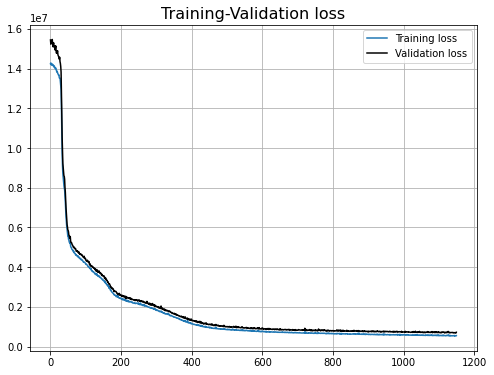

In [23]:
plt.figure(figsize = (8,6))
plt.plot(train_losses[50:])
plt.plot(val_losses[50:], '-k')
plt.title('Training-Validation loss', fontsize = 16)
plt.grid()
plt.legend(['Training loss','Validation loss'])

# Evalute on the test data

### Scale the test data before evaluating the model

In [ ]:
Test_scaler_x = preprocessing.MinMaxScaler(feature_range=feature_range).fit(X_test) # maybe try another for X?
X_Test_scaled = Test_scaler_x.transform(X_test)

predictions = model(torch.tensor(X_Test_scaled).float().to(device)).cpu().detach().numpy()
test_targets = y_test.values

In [ ]:
for idx, ch in enumerate(df.columns.tolist()[8:]):
  # issues with 2 and 7
    plt.figure(idx, figsize = (8,6))
    sns.scatterplot(x = predictions[:,idx], y = test_targets[:,idx])
    plt.title(f'DELs: {ch}', fontsize = 20)
    plt.xlabel('Predictions [kNm]', fontsize = 12)
    plt.ylabel('Targets [kNm]')

In [ ]:
mse_list = []
r2_score_list = []
for i in range(len(df.columns.tolist()[8:])):
    #print(f'MSE {AllTargetData.columns[i]} Channel : \n {mean_squared_error(AllTargetData.values[:,i], Yout[:,i])}')
    mse_list.append(mean_squared_error(test_targets[:,i], predictions[:,i]))
    r2_score_list.append(r2_score(test_targets[:,i], predictions[:,i]))
 

 # Compute the normalized mean square error:
Norm_RMSE = np.sqrt(np.array(mse_list)) / y_test.describe().loc['mean'].values

In [ ]:
fig = plt.figure(figsize= (10,4)) 
sns.barplot(x= df.columns.tolist()[8:], y= r2_score_list) 
plt.ylim([min(r2_score_list)*0.92,max(r2_score_list)*1.02])
plt.ylabel('R2 score', fontsize = 20)
plt.grid()

In [ ]:
fig = plt.figure(figsize= (10,4)) 
sns.barplot(x= df.columns.tolist()[8:], y= Norm_RMSE) 
plt.ylim([0,max(Norm_RMSE)*1.02])
plt.ylabel('Normalized Root Mean Square Error', fontsize = 20)
plt.grid()

# ============================================================
# ==========================Section 2 ==========================
# ============================================================
### Compare versus the wind2loads neural net

In [ ]:
error on purpose

In [ ]:
from w2l import neuralnets

In [ ]:
# define the model using the same net architecture, and train for the same number of epochs using the previously batch size as well.
w2l_net = neuralnets.ann(layersizes = [input_size, num_hid_1, num_hid_2, output_channels],
                       params = {'minibatchsize':64, 'nepochs':500}, 
                       output_style = 'None',
                        testratios = [0.7, 0.3, 0.])

In [ ]:
# train using the data from the first split
Outdata = w2l_net.train(X.values,y.values)

In [ ]:
w2l_net.params

In [ ]:
Outdata.keys()

$\color{red}{\text{Why 500 epochs tho}}$

In [ ]:
plt.plot(Outdata['Jhist'][50:])


In [ ]:
Yout = w2l_net.predict(X_test.values) 

In [ ]:
for idx, ch in enumerate(df.columns.tolist()[8:]):
  # issues with 2 and 7
    plt.figure(idx, figsize = (8,6))
    sns.scatterplot(Yout[:,idx],test_targets[:,idx])
    sns.scatterplot(predictions[:,idx],test_targets[:,idx])
    plt.title(f'DELs: {ch}', fontsize = 20)
    plt.legend(['W2L','PyTorch'])
    plt.xlabel('Predictions [kNm]', fontsize = 12)
    plt.ylabel('Targets [kNm]')

In [ ]:
W2L_mse_list = []
W2L_r2_score_list = []
for i in range(len(df.columns.tolist()[8:])):
    #print(f'MSE {AllTargetData.columns[i]} Channel : \n {mean_squared_error(AllTargetData.values[:,i], Yout[:,i])}')
    W2L_mse_list.append(mean_squared_error(test_targets[:,i], Yout[:,i]))
    W2L_r2_score_list.append(r2_score(test_targets[:,i], Yout[:,i]))
    
W2L_Norm_RMSE = np.sqrt(np.array(W2L_mse_list)) / y_test.describe().loc['mean'].values

In [ ]:
fig = plt.figure(figsize= (12,6)) 
sns.barplot(x= df.columns.tolist()[8:], y= W2L_r2_score_list) 
plt.ylim([min(W2L_r2_score_list)*0.92,max(W2L_r2_score_list)*1.02])
plt.ylabel('R2 score', fontsize = 20)
plt.grid()

# Compare Wind2Loads net versus PyTorch implementation

In [ ]:
barplot_lst = []
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst.append(['pytorch',ch,r2_score_list[i]])
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst.append(['W2L',ch,W2L_r2_score_list[i]])  

In [ ]:
df_comparison = pd.DataFrame(barplot_lst,
                  columns=['Model','channel','r2'])

In [ ]:
plt.figure(figsize=(12,6))
df_comparison.pivot("channel", "Model", "r2").plot(kind='bar')
plt.ylim([min(r2_score_list)*0.98,max(r2_score_list)*1.02])
plt.title('R2', fontsize = 18)
plt.show()

In [ ]:
barplot_lst_NMSE = []
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst_NMSE.append(['pytorch',ch , Norm_RMSE[i]])
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst_NMSE.append(['W2L', ch, W2L_Norm_RMSE[i]])

In [ ]:
df_NRMSE_comparison = pd.DataFrame(barplot_lst_NMSE,
                  columns=['Model','channel','NRMSE'])



In [ ]:
plt.figure(figsize=(14,6))
df_NRMSE_comparison.pivot("channel", "Model", "NRMSE").plot(kind='bar')
plt.ylim([0,max(W2L_Norm_RMSE)*1.02])
plt.show()